In [1]:
import requests
import json
from bs4 import BeautifulSoup
import pandas as pd
import datetime as dt
import re
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

We plan to scrape reviews from the portal Trustpilot, to create a review and sentiment analysis.

In this notebook, we will simply create the function to scraped the required data to run the analysis reporting.

In [2]:
# We pass the url to use as example to be able to fetch the required columns:

#'review_id'
#'review_title'
#'review_date'
#'review_rating'
#'review_content'
#'review_location'
    
url ="https://www.trustpilot.com/review/expondo.com"
# 3. download html with a get request. Use the function request.get() and store the output in response
response = requests.get(url)
# 200 status code means OK! response.status_code
print(response.status_code)

200


In [3]:
# we launch the html.parser from beautiful soup and check how the structure of the previously passed url looks like:

soup = BeautifulSoup(response.text, 'html.parser')
# 4.2. check that the html code looks like it should
print(soup.prettify())

<!DOCTYPE html>
<html lang="en-US">
 <head>
  <meta charset="utf-8"/>
  <meta content="width=device-width, initial-scale=1" name="viewport"/>
  <link href="https://cdn.trustpilot.net/brand-assets/4.3.0/favicons/favicon.ico" rel="shortcut icon" type="image/x-icon"/>
  <link href="/manifest.json" rel="manifest"/>
  <meta content="Trustpilot" name="application-name"/>
  <meta content="#1c1c1c" name="theme-color"/>
  <link href="https://cdn.trustpilot.net/brand-assets/4.3.0/favicons/apple-touch-icon.png" rel="apple-touch-icon" sizes="180x180"/>
  <link href="https://cdn.trustpilot.net/brand-assets/4.3.0/favicons/favicon-32x32.png" rel="icon" sizes="32x32" type="image/png"/>
  <link href="https://cdn.trustpilot.net/brand-assets/4.3.0/favicons/favicon-16x16.png" rel="icon" sizes="16x16" type="image/png"/>
  <link color="#00b67a" href="https://cdn.trustpilot.net/brand-assets/4.3.0/favicons/safari-pinned-tab.svg" rel="mask-icon"/>
  <meta content="Trustpilot" name="apple-mobile-web-app-title"/

In [4]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from datetime import datetime
import re

def scrape_trustpilot_reviews(url, from_page, to_page):
    review_id = []
    review_title = []
    review_date = []
    review_rating = []
    review_content = []
    review_location = []
    page_number = []

    # We want to iterate through the pages prvovided by the user, which shall be sorted by date in descending order
    for i in range(from_page, to_page + 1):
        current_url = f"{url}?page={i}&sort=recency"
        response = requests.get(current_url)
        
        if response.status_code != 200:
            print(f"Error fetching page {i}. Status code: {response.status_code}")
            continue

        soup = BeautifulSoup(response.text, 'html.parser')
        
        # We iterate through all the exsiting reviews to fetch the id, title, date, rating, content and location.

        for review in soup.find_all('section', class_='styles_reviewsContainer__3_GQw'):
            # review_id
            rev_id = [re.search(r'/reviews/([a-f\d]+)', elem['href']).group(1) for elem in soup.select("div.styles_reviewContent__0Q2Tg a") if elem.parent]
            review_id.extend(rev_id)

            # title
            title = [elem.get_text().replace("\n", "").replace("\t", "") for elem in soup.select("div a h2")]
            review_title.extend(title)

            # date
            date = [
                datetime.strptime(elem.get_text().replace("\n", "").replace("\t", "").replace("Date of experience: ", ""),
                                  "%B %d, %Y").strftime("%d/%m/%Y")
                for elem in soup.select("article section div p.typography_body-m__xgxZ_")
            ]
            review_date.extend(date)

            # rating
            rating = [int(elem['data-service-review-rating']) for elem in
                      soup.select('.styles_reviewHeader__iU9Px[data-service-review-rating]')]
            review_rating.extend(rating)

            # content
            for div_element in soup.find_all('div', class_='styles_reviewContent__0Q2Tg'):
                p_element = div_element.find('p',
                                             class_='typography_body-l__KUYFJ typography_appearance-default__AAY17 typography_color-black__5LYEn',
                                             attrs={'data-service-review-text-typography': 'true'})

                if p_element:
                    review_text = p_element.get_text(strip=True)
                    review_content.append(review_text)
                else:
                    review_content.append("")

            # location
            location = [
                elem.get_text(strip=True)
                for elem in soup.select("article div.typography_appearance-subtle__8_H2l span")
                if elem.find_parent("div", class_="styles_consumerExtraDetails__fxS4S")
            ]
            review_location.extend(location)

            # For each looping we append the page number to stop the looping, once the page provided by the user is reached:

            page_number.append(i)


    # we save the corresponding list into a dictionnary
    data = {
        'review_id': review_id,
        'review_title': review_title,
        'review_date': review_date,
        'review_rating': review_rating,
        'review_content': review_content,
        'review_location': review_location,
    }
    # We format the date as date
    data['review_date'] = pd.to_datetime(data['review_date'], format='%d/%m/%Y')

    # We createa DataFrame out of the dictionnary.
    df = pd.DataFrame(data)
    return df


In [10]:
data = scrape_trustpilot_reviews("https://www.trustpilot.com/review/expondo.com", 1, 3)

In [11]:
data

,review_id,review_title,review_date,review_rating,review_content,review_location
0,65b356989fc6ec42f5d5e5ae,The order has arrived as promised,2024-01-25,4,The order has arrived as promised. All was gre...,BG
1,65aed6b600af4883acaf8caf,"TIG (WIG) welder, model S-WIGMA 200PDC",2024-01-22,5,"I ordered a TIG (WIG) / MMA welder, model S-WI...",AT
2,65b21547adf5d0f2623c41c0,I would buy an electronic scale…I have no one ...,2024-01-18,1,I would buy an electronic scale (Counting scal...,RO
3,65a3c4680208eaa47b381c4d,The product arrived on time all the…,2024-01-12,5,The product arrived on time all the assembly d...,IE
4,65a68b82126d92f1f9a4d330,Awesome experience,2024-01-15,5,Awesome experience. We had to use their custom...,BG
5,65b55dc3091e2ef131650500,"do not buy from this company at any cost, beca...",2024-01-27,1,"i bought a space heater from this company, it ...",IE
6,659fcc8b2e14391e7d9d5597,Good and fast delivery,2023-12-27,5,Good and fast delivery of this amazing standin...,CZ
7,65830d582df3bc042399e13d,Super fast shopping,2023-12-20,5,"Super fast shopping, I found my product quickl...",PL
8,65950136507439cdcbfaf53b,I bought a product from Expondo,2023-12-01,4,"I bought a product from Expondo, but it was no...",NO
9,65b38f09a6588366d0cc1cae,Straight forward,2024-01-26,5,"Straight forward, no fuss.",GB


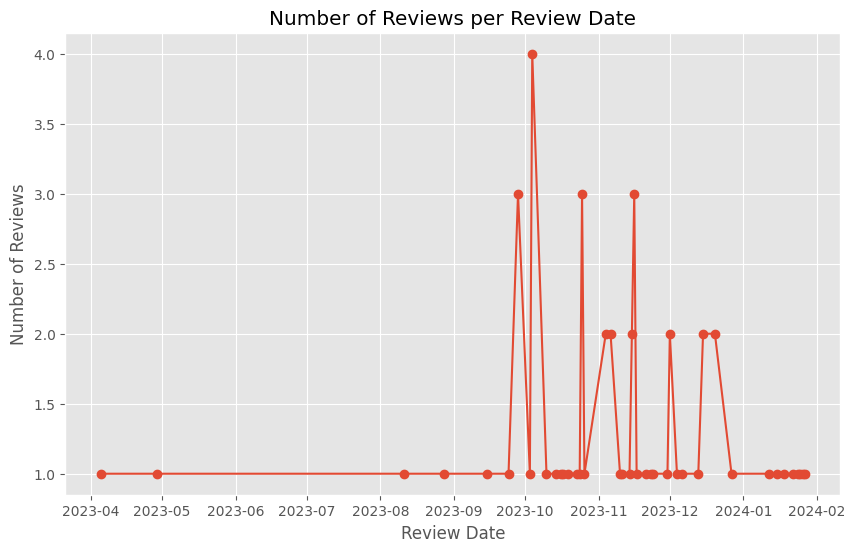

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your data is stored in a DataFrame named 'df'
# If not, replace 'df' with your actual DataFrame name

# Convert 'review_date' to datetime format
#result_df['review_date'] = pd.to_datetime(result_df['review_date'])

# Group by 'review_date' and count the number of reviews for each date
reviews_per_date = result_df.groupby('review_date').size().reset_index(name='num_reviews')

# Plot the data as a line plot
plt.figure(figsize=(10, 6))
plt.plot(reviews_per_date['review_date'], reviews_per_date['num_reviews'], marker='o', linestyle='-')

# Customize the plot
plt.title('Number of Reviews per Review Date')
plt.xlabel('Review Date')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()

In [16]:
data['review_rating'] = pd.to_numeric(data['review_rating'], errors='coerce')

In [17]:
data.dtypes

review_id                  object
review_title               object
review_date        datetime64[ns]
review_rating               int64
review_content             object
review_location            object
dtype: object

In [26]:
import pandas as pd

# Assuming your DataFrame is named 'data' and the column you want to convert is 'review_rating'
# If not, replace 'data' and 'review_rating' with your actual DataFrame and column names

# Convert the 'review_date' to a period (month) and calculate the average review rating
avg_rating_per_month = (
    data.groupby(data['review_date'].dt.to_period("M"))['review_rating']
    .mean()
    .round(1)
    .reset_index()
)

# Sort the result by 'review_date' in ascending order
avg_rating_per_month = avg_rating_per_month.sort_values('review_date')

# Display the result
avg_rating_per_month.dtypes

review_date      period[M]
review_rating      float64
dtype: object

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import streamlit as st

# Assuming your DataFrame is named 'avg_rating_per_month'
# If not, replace 'avg_rating_per_month' with your actual DataFrame name

avg_rating_per_month = (
    data.groupby(data['review_date'].dt.to_period("M"))['review_rating']
    .mean()
    .round(1)
    .reset_index()

# Convert 'review_date' to datetime
avg_rating_per_month['review_date'] = pd.to_datetime(avg_rating_per_month['review_date'].astype(str))

# Sort the DataFrame by 'review_date' in chronological order
avg_rating_per_month = avg_rating_per_month.sort_values('review_date')

# Convert 'review_date' back to string for plotting (optional)
avg_rating_per_month['review_date'] = avg_rating_per_month['review_date'].dt.strftime('%Y-%m')

# Plot the data as a line chart using Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(avg_rating_per_month['review_date'], avg_rating_per_month['review_rating'], marker='o', linestyle='-')

# Customize the plot
ax.set_title('Average Review Rating per Month')
ax.set_xlabel('Month')
ax.set_ylabel('Average Review Rating')
ax.grid(False)

# Display the plot using Streamlit
st.pyplot(fig)

DeltaGenerator()

In [30]:
avg_rating_per_month

,review_date,review_rating
0,2023-04,4.5
1,2023-08,5.0
2,2023-09,4.2
3,2023-10,4.2
4,2023-11,4.1
5,2023-12,3.7
6,2024-01,3.5


In [43]:
count_rating_stars = (
    data.groupby([data['review_date'].dt.to_period("M"), 'review_rating'])
    .size()
    .reset_index()
)
# Display the resulting DataFrame
print(count_rating_stars)


   review_date  review_rating   0
0      2023-04              4   1
1      2023-04              5   1
2      2023-08              5   2
3      2023-09              1   1
4      2023-09              5   4
5      2023-10              1   3
6      2023-10              5  13
7      2023-11              1   3
8      2023-11              3   1
9      2023-11              4   1
10     2023-11              5  12
11     2023-12              1   3
12     2023-12              4   1
13     2023-12              5   6
14     2024-01              1   2
15     2024-01              2   1
16     2024-01              4   1
17     2024-01              5   4


In [34]:
avg_rating_stars

,review_date,review_rating
0,2023-04,4.5
1,2023-08,5.0
2,2023-09,4.2
3,2023-10,4.2
4,2023-11,4.1
5,2023-12,3.7
6,2024-01,3.5


In [45]:
#df.groupby(by=["b"]).sum()
data.groupby(["review_date","review_rating"]).size()

review_date  review_rating
2023-04-05   5                1
2023-04-29   4                1
2023-08-11   5                1
2023-08-28   5                1
2023-09-15   5                1
2023-09-24   1                1
2023-09-28   5                3
2023-10-03   5                1
2023-10-04   1                1
             5                3
2023-10-10   5                1
2023-10-14   1                1
2023-10-16   5                1
2023-10-17   5                1
2023-10-19   5                1
2023-10-23   5                1
2023-10-24   5                1
2023-10-25   1                1
             5                2
2023-10-26   5                1
2023-11-04   3                1
             5                1
2023-11-06   1                1
             5                1
2023-11-10   5                1
2023-11-11   5                1
2023-11-14   5                1
2023-11-15   5                2
2023-11-16   5                3
2023-11-17   4                1
2023-11-21   

In [46]:
import pandas as pd

# Assuming 'data' is your DataFrame containing the reviews
data['month_year'] = data['review_date'].dt.to_period("M")

# Optionally, convert 'month_year' back to string for better readability
data['month_year_str'] = data['month_year'].dt.strftime('%Y-%m')

# Display the resulting DataFrame
print(data)


                   review_id  \
0   65b356989fc6ec42f5d5e5ae   
1   65aed6b600af4883acaf8caf   
2   65b21547adf5d0f2623c41c0   
3   65a3c4680208eaa47b381c4d   
4   65a68b82126d92f1f9a4d330   
5   65b55dc3091e2ef131650500   
6   659fcc8b2e14391e7d9d5597   
7   65830d582df3bc042399e13d   
8   65950136507439cdcbfaf53b   
9   65b38f09a6588366d0cc1cae   
10  651ee50f5ae03db6af4d9088   
11  64d6ab086e7a34ff1532b3bc   
12  6511601f80fac02db8231204   
13  652311a3869431546e87775e   
14  645de01107a8b3cc97f0ae69   
15  6437c2d14583df412d44dd41   
16  65054a4c02cded1fdfd09189   
17  6582db9ab65fe5974bf373c3   
18  6517ee277e96d0f9013c5714   
19  65b2afaca9955a7267e00752   
20  6580cfc217f68235231e15e8   
21  65800dd6b78a37a576fb66b5   
22  65799e125f9055449f5da2e8   
23  6575ac0845d6af48891bc1ea   
24  65702b3a874656df3a860115   
25  656f73d9d4c5be75b05e05d8   
26  656c8e019fb6285b8404c99b   
27  6569f3461696b511eb400570   
28  656519d49f0e1aa309f0bde4   
29  656312df732fe33f1a684dab   
30  655c

In [47]:
data.head()

,review_id,review_title,review_date,review_rating,review_content,review_location,month_year,month_year_str
0,65b356989fc6ec42f5d5e5ae,The order has arrived as promised,2024-01-25,4,The order has arrived as promised. All was gre...,BG,2024-01,2024-01
1,65aed6b600af4883acaf8caf,"TIG (WIG) welder, model S-WIGMA 200PDC",2024-01-22,5,"I ordered a TIG (WIG) / MMA welder, model S-WI...",AT,2024-01,2024-01
2,65b21547adf5d0f2623c41c0,I would buy an electronic scale…I have no one ...,2024-01-18,1,I would buy an electronic scale (Counting scal...,RO,2024-01,2024-01
3,65a3c4680208eaa47b381c4d,The product arrived on time all the…,2024-01-12,5,The product arrived on time all the assembly d...,IE,2024-01,2024-01
4,65a68b82126d92f1f9a4d330,Awesome experience,2024-01-15,5,Awesome experience. We had to use their custom...,BG,2024-01,2024-01


In [104]:
data.to_csv("data_wordcloud.csv",index=False)

In [48]:
data.groupby(["month_year_str","review_rating"]).size()

month_year_str  review_rating
2023-04         4                 1
                5                 1
2023-08         5                 2
2023-09         1                 1
                5                 4
2023-10         1                 3
                5                13
2023-11         1                 3
                3                 1
                4                 1
                5                12
2023-12         1                 3
                4                 1
                5                 6
2024-01         1                 2
                2                 1
                4                 1
                5                 4
dtype: int64

In [52]:
len(data)

60

In [69]:
vg_rating_per_month = data.groupby(['month_year_str',"review_rating"]).agg({'review_rating': 'mean'}).round(2)

In [71]:
vg_rating_per_month

,review_rating
month_year_str,
2023-04,4.50
2023-08,5.00
2023-09,4.20
2023-10,4.25
2023-11,4.12
2023-12,3.70
2024-01,3.50


In [72]:

# Calculate the average rating and number of reviews per location
avg_rating_per_location = data.groupby('review_location').agg({'review_rating': ['mean', 'count']})

# Rename the columns for clarity
avg_rating_per_location.columns = ['avg_rating', 'num_reviews']

# Sort the DataFrame by the number of reviews in descending order
avg_rating_per_location = avg_rating_per_location.sort_values(by='num_reviews', ascending=False)

# Display the result
print(avg_rating_per_location)


                 avg_rating  num_reviews
review_location                         
GB                 3.555556           18
IE                 4.000000            8
HU                 5.000000            5
RO                 4.000000            4
PL                 4.750000            4
NL                 5.000000            3
AT                 3.000000            2
NO                 2.500000            2
CH                 5.000000            2
CZ                 3.500000            2
DE                 5.000000            2
ES                 5.000000            2
BG                 4.500000            2
HR                 5.000000            1
IT                 1.000000            1
GR                 4.000000            1
SE                 5.000000            1


In [76]:
avg_rating = data["review_rating"].mean()
avg_rating

4.05

In [78]:
number_reviews=data["review_id"].nunique()

In [80]:
number_reviews

58

In [82]:
 data.groupby('review_location')['review_rating'].mean().reset_index().round(2)

,review_location,review_rating
0,AT,3.00
1,BG,4.50
2,CH,5.00
3,CZ,3.50
4,DE,5.00
5,ES,5.00
6,GB,3.56
7,GR,4.00
8,HR,5.00
9,HU,5.00


In [96]:
import streamlit as st
from wordcloud import WordCloud
from textblob import TextBlob
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk

# Download NLTK stopwords if not already downloaded
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

# Sample text data
text_data = """
This is some sample text for creating a word cloud.
You can replace this with your own text data.
Word clouds are a fun way to visualize word frequency!
"""

# Function to preprocess text, remove stop words, and filter by sentiment
def preprocess_text(text):
    # Remove punctuation and convert to lowercase
    text = ''.join([char.lower() for char in text if char.isalnum() or char.isspace()])

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word.lower() not in stop_words]

    # Filter words based on sentiment (positive or negative)
    blob = TextBlob(' '.join(words))
    positive_words = [word.lower() for word, _ in blob.tags if 'JJ' in _]
    negative_words = [word.lower() for word, _ in blob.tags if 'JJ' in _ and blob.sentiment.polarity < 0]

    return positive_words,negative_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\e.sansebastian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\e.sansebastian\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [103]:
# Convert the elements in 'processed_review' column to strings
data['processed_review'] = data['processed_review'].apply(lambda x: ' '.join(map(str, x)))

# Call the preprocess_text function
processed_data = data['processed_review'].apply(preprocess_text)

# Separate the DataFrame columns into two lists
positive_words = processed_data.apply(lambda x: x[0])
negative_words = processed_data.apply(lambda x: x[1])

# Print the positive words
print("Positive Words:")
print(positive_words)


Positive Words:
0                                          [u, u, n, n]
1     [u, n, u, n, u, n, u, n, u, n, n, n, f, u, u, ...
2                     [n, u, u, n, u, n, n, u, u, n, u]
3                                                   [n]
4                                                [u, n]
5                                 [u, u, u, n, u, u, u]
6                                                    []
7                                          [u, n, u, u]
8                                                [u, n]
9                                                    []
10                                            [n, n, n]
11                                                  [n]
12                                      [u, f, u, n, n]
13                                   [n, u, u, u, n, n]
14                    [f, e, u, u, n, n, u, n, u, n, u]
15                                [n, n, n, u, u, n, u]
16                                                   []
17                              

In [97]:
data['processed_review'] = data['review_content'].apply(preprocess_text)

In [98]:
data.head()

,review_id,review_title,review_date,review_rating,review_content,review_location,month_year,month_year_str,processed_review
0,65b356989fc6ec42f5d5e5ae,The order has arrived as promised,2024-01-25,4,The order has arrived as promised. All was gre...,BG,2024-01,2024-01,"([promised, great, surprised, bulgarian, local..."
1,65aed6b600af4883acaf8caf,"TIG (WIG) welder, model S-WIGMA 200PDC",2024-01-22,5,"I ordered a TIG (WIG) / MMA welder, model S-WI...",AT,2024-01,2024-01,"([tig, quick, devicefirst, fine, current, curr..."
2,65b21547adf5d0f2623c41c0,I would buy an electronic scale…I have no one ...,2024-01-18,1,I would buy an electronic scale (Counting scal...,RO,2024-01,2024-01,"([electronic, scale, worse, use, stupid, concr..."
3,65a3c4680208eaa47b381c4d,The product arrived on time all the…,2024-01-12,5,The product arrived on time all the assembly d...,IE,2024-01,2024-01,"([handy, clear, great], [])"
4,65a68b82126d92f1f9a4d330,Awesome experience,2024-01-15,5,Awesome experience. We had to use their custom...,BG,2024-01,2024-01,"([awesome, outstanding], [])"


In [99]:
positive_words

NameError: name 'positive_words' is not defined

In [90]:
def generate_word_lists(text):
    # Remove punctuation and convert to lowercase
    text = ''.join([char.lower() for char in text if char.isalnum() or char.isspace()])

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word.lower() not in stop_words]

    # Analyze sentiment using TextBlob
    blob = TextBlob(' '.join(words))
    positive_words = [word.lower() for word, _ in blob.tags if 'JJ' in _ and blob.sentiment.polarity > 0]
    negative_words = [word.lower() for word, _ in blob.tags if 'JJ' in _ and blob.sentiment.polarity < 0]

    return positive_words, negative_words

# Example usage


In [93]:
def generate_word_cloud(text):
    if not text:
        st.warning("No words to generate a word cloud.")
        return

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Display the generated word cloud using Matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    st.pyplot()


In [94]:
data["processed_review"].apply(generate_word_cloud)

C:\Users\e.sansebastian\AppData\Local\Temp\ipykernel_24356\1957472713.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 5))


0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
21    None
22    None
23    None
24    None
25    None
26    None
27    None
28    None
29    None
30    None
31    None
32    None
33    None
34    None
35    None
36    None
37    None
38    None
39    None
40    None
41    None
42    None
43    None
44    None
45    None
46    None
47    None
48    None
49    None
50    None
51    None
52    None
53    None
54    None
55    None
56    None
57    None
58    None
59    None
Name: processed_review, dtype: object